In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# The Bias-Variance Trade-off

In this notebook, we will demonstrate the bias-variance trade-off using a simple example.

Let us start by defining the true function $f\colon \mathbb{R} \to \mathbb{R}$ that we want to learn from noisy data. We will use the function $f(x) = \cos(\frac{x}{2})$.

In [4]:
def f(x):
    return np.cos(x / 2)

Let us plot $f$ in the interval $[-10, 10]$.

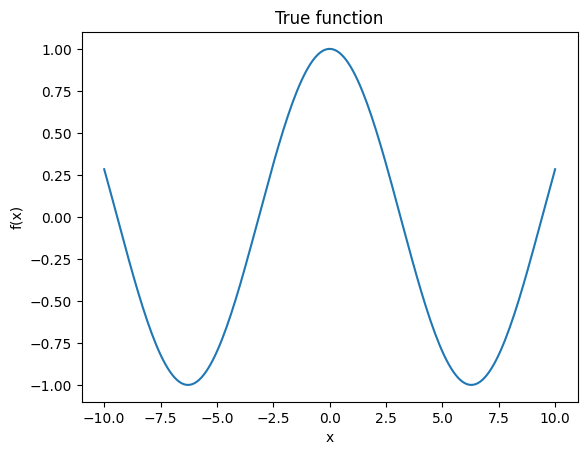

In [5]:
grid = np.linspace(-10, 10, 200)
plt.plot(grid, f(grid))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("True function")
plt.show()

The function `generate_data` generates noisy data points from the true function $f$ as follows:

1. Sample $n$ points $x_1, \ldots, x_n$ uniformly at random from the interval $[-10, 10]$ (and sort them in increasing order).
2. Compute the corresponding noisy values $y_i = f(x_i) + \epsilon_i$, where $\epsilon_i$ is a random number drawn from a normal distribution with mean $0$ and standard deviation $\sigma$ (`sigma`).

In [6]:
def generate_data(n, sigma, rng):
    x = np.sort(rng.uniform(-10, 10, n)) #np.linspace(-10, 10, n)
    y = f(x) + rng.normal(loc=0, scale=sigma, size=n)
    return x, y

Let us test the function by generating some noisy data points and plotting them together with the true function $f$.

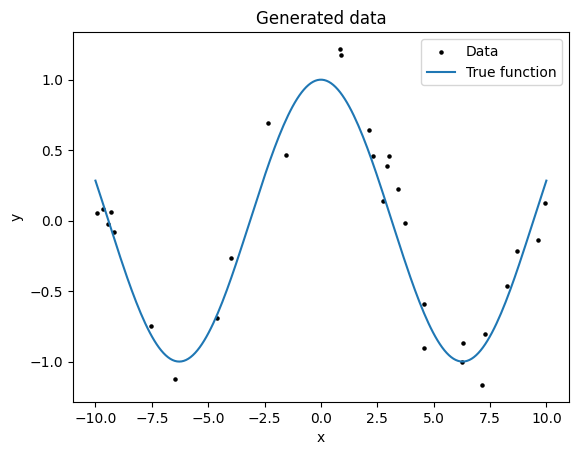

In [7]:
n = 30
sigma = 0.2
seed = 0
rng = np.random.default_rng(seed)

x, y = generate_data(n, sigma, rng)
plt.scatter(x, y, s=5, color="black", label="Data")
plt.plot(grid, f(grid), label="True function")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Generated data")
plt.legend()
plt.show()

Now, let us fit a polynomial of degree $d\in\{1,2,3,5,15\}$ to the noisy data points using `sklearn`'s `PolynomialFeatures` and `LinearRegression`. We will plot the fitted polynomial together with the true function $f$ and the noisy data points.

In [8]:
def fit_polynomial(x, y, degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression(fit_intercept=False))
    model.fit(x[:, np.newaxis], y)
    return model

(30,) (30,)
Degree 1: MSE = 0.4500133664885192
Degree 2: MSE = 0.39394159368448173
Degree 3: MSE = 0.393481217711053
Degree 5: MSE = 0.043456340815997176
Degree 15: MSE = 0.019680118571665045


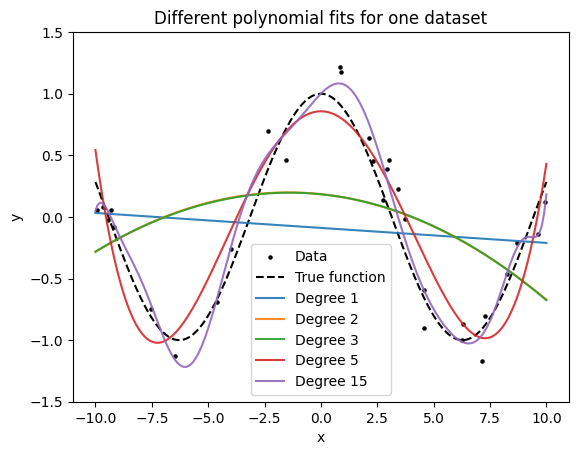

In [9]:
plt.scatter(x, y, s=5, color="black", label="Data")
plt.plot(grid, f(grid), label="True function", color="black", linestyle="--")

print(x.shape, y.shape)
for degree in [1, 2, 3, 5, 15]:
    model = fit_polynomial(x, y, degree)
    prediction = model.predict(grid[:, np.newaxis])
    mse = mean_squared_error(f(grid), prediction)
    print(f"Degree {degree}: MSE = {mse}")
    y_pred = model.predict(grid[:, np.newaxis])
    plt.plot(grid, y_pred, label=f"Degree {degree}", alpha=0.9)

# limit the y-axis to make the plot more readable
plt.ylim(-1.5, 1.5)
plt.xlim(-11, 11)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Different polynomial fits for one dataset")
plt.show()

**Questions:** 

1. Which of the polynomial fits are underfitting, which are overfitting? 
2. Which one would you consider as the best fit based only on the plot?
3. What is the MSE of the degree $15$ polynomial on the training data? (Feel free to create a new code cell to compute this.)
4. Given a new data point $x$, which of the polynomial fits would you expect to give the best prediction of $f(x)$?

For each degree $d\in\{1,3,6,15\}$, we will generate $100$ noisy data sets with $20$ points each, and fit a polynomial of degree $d$ to the data. We will plot the fitted polynomials together with the true function $f$. This will show the variance of the fitted polynomial for each degree.

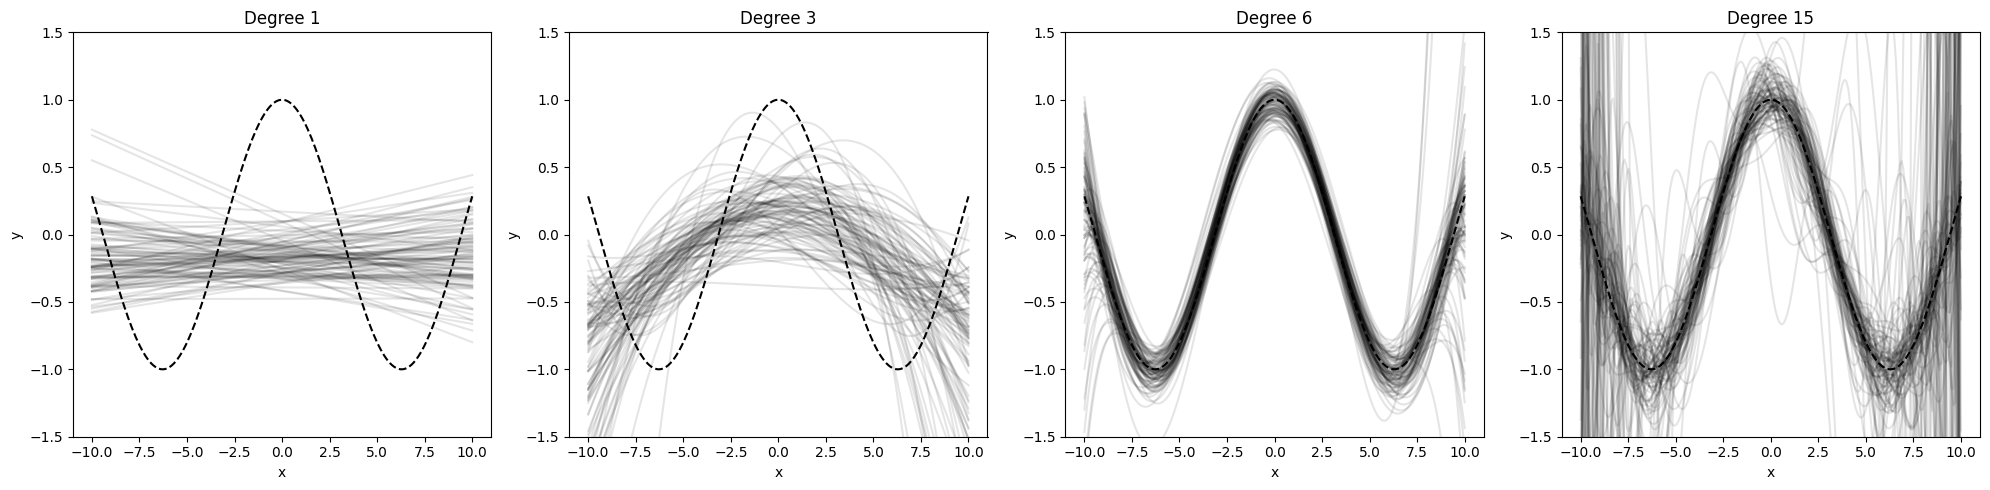

In [10]:
n = 30
sigma = 0.2
seed = 0
rng = np.random.default_rng(seed)

grid = np.linspace(-10, 10, 200)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for ax, degree in zip(axs, [1, 3, 6, 15]):
    ax.plot(grid, f(grid), label="True function", color="black", linestyle="--")
    for i in range(100):
        x, y = generate_data(n, sigma, rng)
        model = fit_polynomial(x, y, degree)
        y_pred = model.predict(grid[:, np.newaxis])
        ax.plot(grid, y_pred, color="black", alpha=0.1)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlim(-11, 11)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Degree {degree}")

plt.tight_layout()
plt.show()

**Question:** What can you observe from the above plots?

## Bias-Variance Trade-off

In practice, we do not have access to the true function $f$, only (noisy) samples. Therefore, we cannot compute the bias and variance of the fitted polynomial directly. However, we can observe the bias-variance trade-off by looking at the MSE of the fitted polynomial on the training data and the test data.

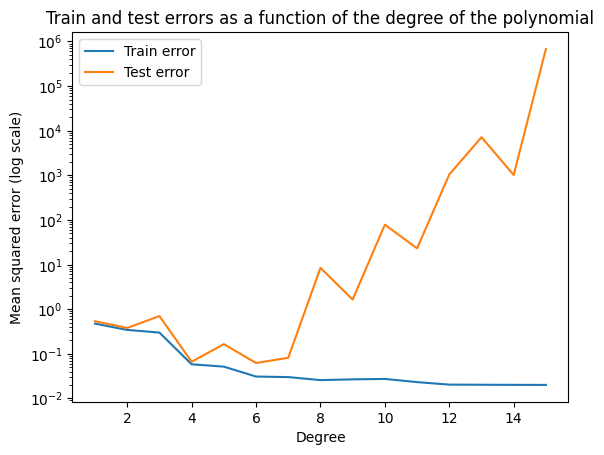

In [11]:
degrees = np.arange(1, 16) # Degrees to consider
n = 30 # Number of data points in each dataset
sigma = 0.2 # Standard deviation of the noise added to the data
k = 50 # Number of datasets to generate (repetitions of the experiment)

seed = 10 # Seed for the random number generator
rng = np.random.default_rng(seed) # Random number generator used to generate the data

test_errors = np.zeros(len(degrees))
train_errors = np.zeros(len(degrees))

x_test, y_test = generate_data(n, sigma, rng)

for degree in degrees:
    for i in range(k):
        x_train, y_train = generate_data(n, sigma, rng)
        model = fit_polynomial(x_train, y_train, degree)
        y_pred_train = model.predict(x_train[:, np.newaxis])
        y_pred_test = model.predict(x_test[:, np.newaxis])
        train_error = mean_squared_error(y_train, y_pred_train)
        test_error = mean_squared_error(y_test, y_pred_test)
        train_errors[degree - 1] += train_error
        test_errors[degree - 1] += test_error
    
    # Average the errors over the k datasets
    train_errors[degree - 1] /= k
    test_errors[degree - 1] /= k

plt.plot(degrees, train_errors, label="Train error")
plt.plot(degrees, test_errors, label="Test error")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Mean squared error (log scale)")
plt.title("Train and test errors as a function of the degree of the polynomial")
plt.legend()
plt.show()


**Question:** What do you observe in the above plot of training and test MSE for different polynomial degrees? Can you detect overfitting and underfitting just by looking at this plot?

Try fitting even higher-degree polynomials and observe the training and test MSE. What do you expect and what do you observe?

If you see the training MSE increasing again for high degrees, you might be a bit surprised. This is most likely due to numerical instability happening when we consider very high powers of the features. For example, $0.5^{20}\approx 0.00000095$.

Since we know the true function $f$ in this simulated scenario, we can estimate the bias and variance directly. We will do this in the next cell and plot the familiar bias-variance trade-off curve.

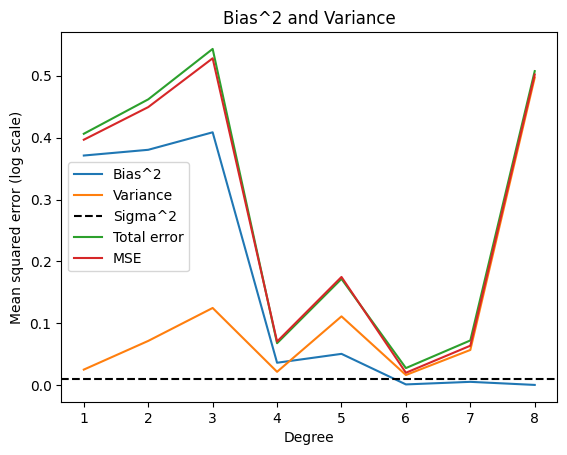

In [12]:
degrees = np.arange(1, 9) # Degrees to consider
n = 30 # Number of data points in each dataset
sigma = 0.1 # Standard deviation of the noise added to the data
k = 50 # Number of datasets to generate (repetitions of the experiment)

seed = 420 # Seed for the random number generator
rng = np.random.default_rng(seed) # Random number generator used to generate the data

biases_squared = np.zeros(len(degrees))
variances = np.zeros(len(degrees))
mse = np.zeros(len(degrees))

x_test, y_test = generate_data(n, sigma, rng)

for degree in degrees:
    y_preds_test = np.zeros((k, n))
    for i in range(k):
        x_train, y_train = generate_data(n, sigma, rng)
        model = fit_polynomial(x_train, y_train, degree)
        y_pred_test = model.predict(x_test[:, np.newaxis])
        y_preds_test[i] = y_pred_test

    y_pred_test_mean = np.mean(y_preds_test, axis=0) # Mean prediction over the k datasets
    biases_squared[degree - 1] = np.mean((f(x_test) - y_pred_test_mean) ** 2)
    variances[degree - 1] = np.mean(np.var(y_preds_test, axis=0))
    mse[degree - 1] = np.mean([mean_squared_error(y_test, y_preds_test[i]) for i in range(k)])

plt.plot(degrees, biases_squared, label="Bias^2")
plt.plot(degrees, variances, label="Variance")
plt.axhline(sigma ** 2, color="black", linestyle="--", label="Sigma^2")
plt.plot(degrees, biases_squared + variances + sigma ** 2, label="Total error")
plt.plot(degrees, mse, label="MSE")
#plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Mean squared error (log scale)")
plt.title("Bias^2 and Variance")
plt.legend()
plt.show()

**Question:** What do you observe in the bias-variance trade-off curve?

The curve may not be as smooth as you would expect. This is due to factors such as the limited number of data points, numerical instability, and the randomness in the data generation process. But it should reflect the general trend of the bias-variance trade-off.